In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d diversisai/fire-segmentation-image-dataset

100% 471M/472M [00:24<00:00, 22.6MB/s]
100% 472M/472M [00:24<00:00, 20.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fire-segmentation-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 115MB/s] 


Epoch [1/25], Train Loss: 0.5540, Train Acc: 0.7110, Test Loss: 0.4339, Test Acc: 0.8463
Epoch [2/25], Train Loss: 0.4732, Train Acc: 0.7528, Test Loss: 0.4339, Test Acc: 0.8294
Epoch [3/25], Train Loss: 0.4387, Train Acc: 0.7807, Test Loss: 0.4675, Test Acc: 0.7736
Epoch [4/25], Train Loss: 0.4150, Train Acc: 0.7933, Test Loss: 0.4946, Test Acc: 0.7264
Epoch [5/25], Train Loss: 0.4032, Train Acc: 0.8001, Test Loss: 0.5252, Test Acc: 0.6791
Epoch [6/25], Train Loss: 0.3928, Train Acc: 0.8089, Test Loss: 0.5575, Test Acc: 0.6554
Epoch [7/25], Train Loss: 0.3844, Train Acc: 0.8127, Test Loss: 0.5817, Test Acc: 0.6470
Epoch [8/25], Train Loss: 0.3771, Train Acc: 0.8166, Test Loss: 0.6093, Test Acc: 0.6385
Epoch [9/25], Train Loss: 0.3676, Train Acc: 0.8254, Test Loss: 0.6340, Test Acc: 0.6368
Epoch [10/25], Train Loss: 0.3637, Train Acc: 0.8278, Test Loss: 0.6709, Test Acc: 0.6132
Epoch [11/25], Train Loss: 0.3630, Train Acc: 0.8280, Test Loss: 0.6768, Test Acc: 0.6132
Epoch [12/25], Trai

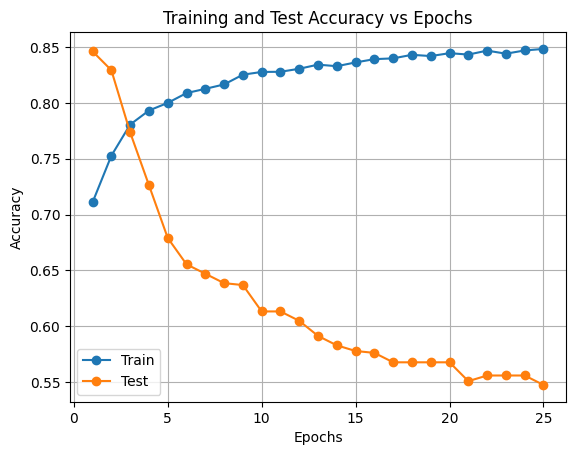

Text(0, 0.5, 'Loss')

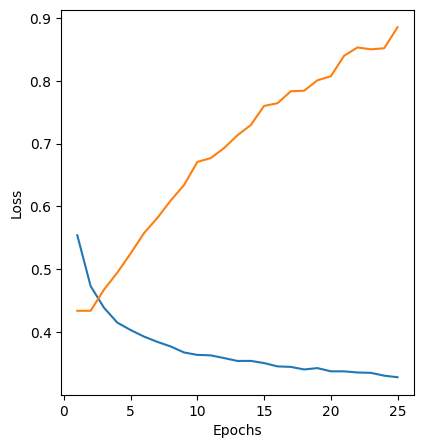

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import pandas as pd

# Define constants
IMG_HEIGHT=256
IMG_WIDTH = 256
BATCH_SIZE = 64
EPOCHS = 25

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_HEIGHT),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),

])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/Image', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Our_Dataset_610', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pre-trained VGG-19 model
base_model = models.vgg19(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = base_model.classifier[6].in_features
base_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.7),  # Adjust dropout rate
    nn.Linear(256, 2),  # Output 2 classes (assuming binary classification)
    nn.LogSoftmax(dim=1)  # Use LogSoftmax for multi-class classification
)

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.SGD(base_model.parameters(), lr=0.001, weight_decay=0.0001)  # Use SGD optimizer

# Lists to store losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
for epoch in range(EPOCHS):
    # Training
    base_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Testing
    base_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    test_acc = correct_test / total_test
    test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


data_accuracy = {
    'Epoch': range(1, EPOCHS + 1),
    'Train Accuracy': train_accs,
    'Test Accuracy': test_accs
}

data_loss = {
    'Epoch': range(1, EPOCHS + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses
}

df_accuracy = pd.DataFrame(data_accuracy)
df_loss = pd.DataFrame(data_loss)

df_accuracy.to_csv('/content/drive/MyDrive/Colab Notebooks/VGG_accuarcy.csv', index=False)
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/VGG_losses.csv', index=False)

avg_train_accuracy = sum(train_accs) / len(train_accs)
avg_test_accuracy = sum(test_accs) / len(test_accs)
avg_train_loss = sum(train_losses) / len(train_losses)
avg_test_loss = sum(test_losses) / len(test_losses)

# Print average accuracies and losses
print("Average Train Accuracy:", avg_train_accuracy)
print("Average Test Accuracy:", avg_test_accuracy)
print("Average Train Loss:", avg_train_loss)
print("Average Test Loss:", avg_test_loss)

# Plotting
plt.plot(range(1, EPOCHS+1), train_accs, marker='o', label='Train')
plt.plot(range(1, EPOCHS+1), test_accs, marker='o', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Prediction: Fire, True Label: Not_Fire
Fire Detected


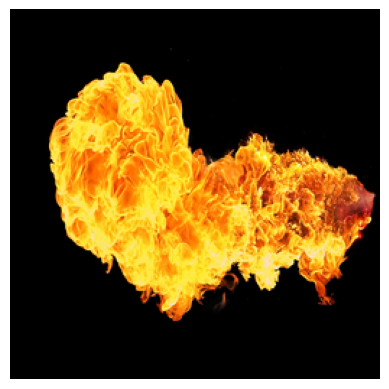

Prediction: Not_Fire, True Label: Fire
Non-Fire Detected


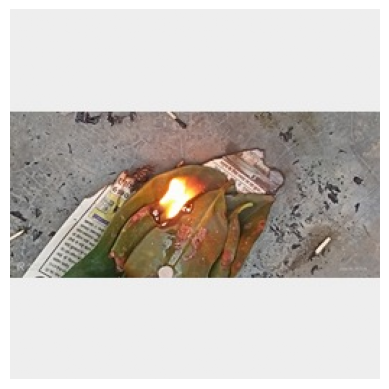

Prediction: Not_Fire, True Label: Fire
Non-Fire Detected


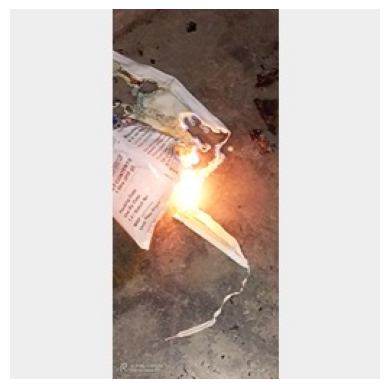

Prediction: Fire, True Label: Fire
Fire Detected


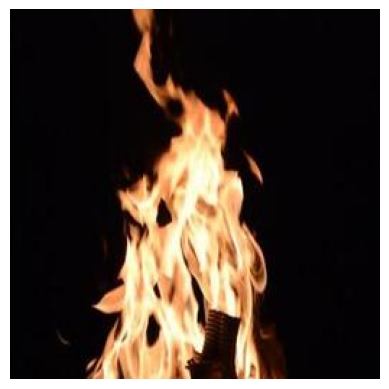

Prediction: Fire, True Label: Fire
Fire Detected


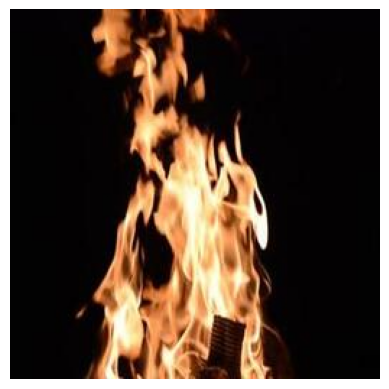

Prediction: Not_Fire, True Label: Fire
Non-Fire Detected


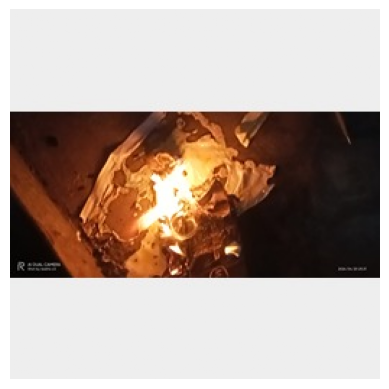

Prediction: Not_Fire, True Label: Fire
Non-Fire Detected


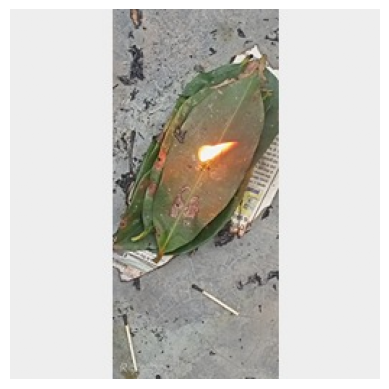

Prediction: Not_Fire, True Label: Not_Fire
Non-Fire Detected


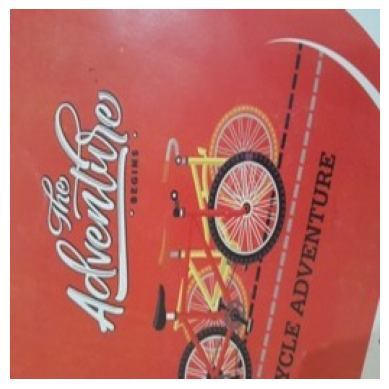

Prediction: Not_Fire, True Label: Fire
Non-Fire Detected


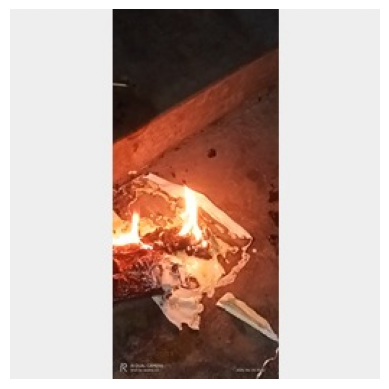

Prediction: Fire, True Label: Fire
Fire Detected


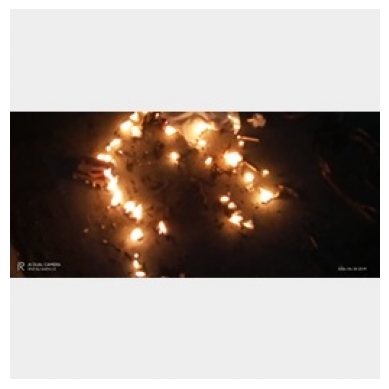

In [7]:
import random

# Set model to evaluation mode
base_model.eval()

# Function to convert class index to class label
def get_class_label(class_idx):
    return train_dataset.classes[class_idx]

# Select random 5 images from the test dataset
random_indices = random.sample(range(len(test_dataset)), 10)

for idx in random_indices:
    image, label = test_dataset[idx]

    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = base_model(image)

    # Get predicted class
    pred_idx = torch.argmax(output, dim=1).item()
    pred_label = get_class_label(pred_idx)

    # Get ground truth label
    true_label = get_class_label(label)

    # Display the result
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
    plt.axis('off')

    # Print predicted label and ground truth label
    print(f'Prediction: {pred_label}, True Label: {true_label}')

    # Determine if it's fire or non-fire
    if pred_label == "Fire":
        print("Fire Detected")
    else:
        print("Non-Fire Detected")

    plt.show()


In [8]:
torch.save(base_model.state_dict(),"/content/drive/MyDrive/VGG19.pth")
